In [13]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [14]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [15]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [16]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [17]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [18]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [19]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [20]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.h5")
    print("Model Saved!")

In [21]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [22]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [23]:
mpath = r'../input/multi-cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Multi Cancer



Total :  Found 130002 files belonging to 8 classes.

For Training :  Found 104002 images belonging to 8 classes.

For Val :  Found 26000 images belonging to 8 classes.

No of Classes :  8
Classes :  ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)              

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
3251/3251 [==============================] - 802s 247ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0409 - val_accuracy: 0.9852

Epoch 00002: val_loss improved from 0.04260 to 0.04087, saving model to Multi CancerMobileNet.h5
Epoch 3/10
3251/3251 [==============================] - 773s 238ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0345 - val_accuracy: 0.9875

Epoch 00003: val_loss improved from 0.04087 to 0.03453, saving model to Multi CancerMobileNet.h5
Epoch 4/10
3251/3251 [==============================] - 785s 241ms/step - loss: 7.5019e-04 - accuracy: 0.9998 - val_loss: 0.0385 - val_accuracy: 0.9869

Epoch 00004: val_loss did not improve from 0.03453
Epoch 5/10
3251/3251 [==============================] - 777s 239ms/step - loss: 6.4952e-04 - accuracy: 0.9999 - val_loss: 0.0189 - val_accuracy: 0.9934

Epoch 00005: val_loss improved from 0.03453 to 0.01892, saving model to Multi CancerMobileNet.h5
Epoch 6/10
3251/3251 [==============================] 

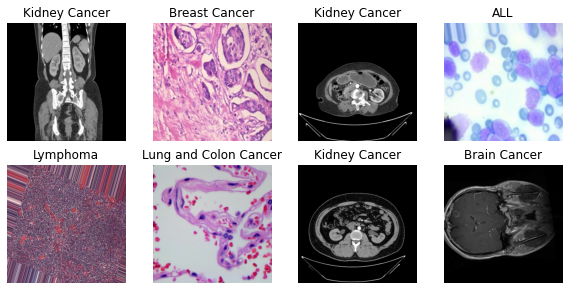

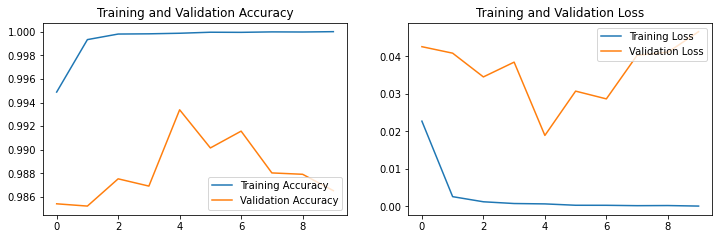

813/813 [==============================] - 126s 155ms/step - loss: 0.0466 - accuracy: 0.9865
Accuracy on the Test Set = 98.65 %
Model Saved!
True :  [0 0 0 ... 7 7 7]
Predicted :  [0 0 0 ... 7 7 7]


<Figure size 432x288 with 0 Axes>

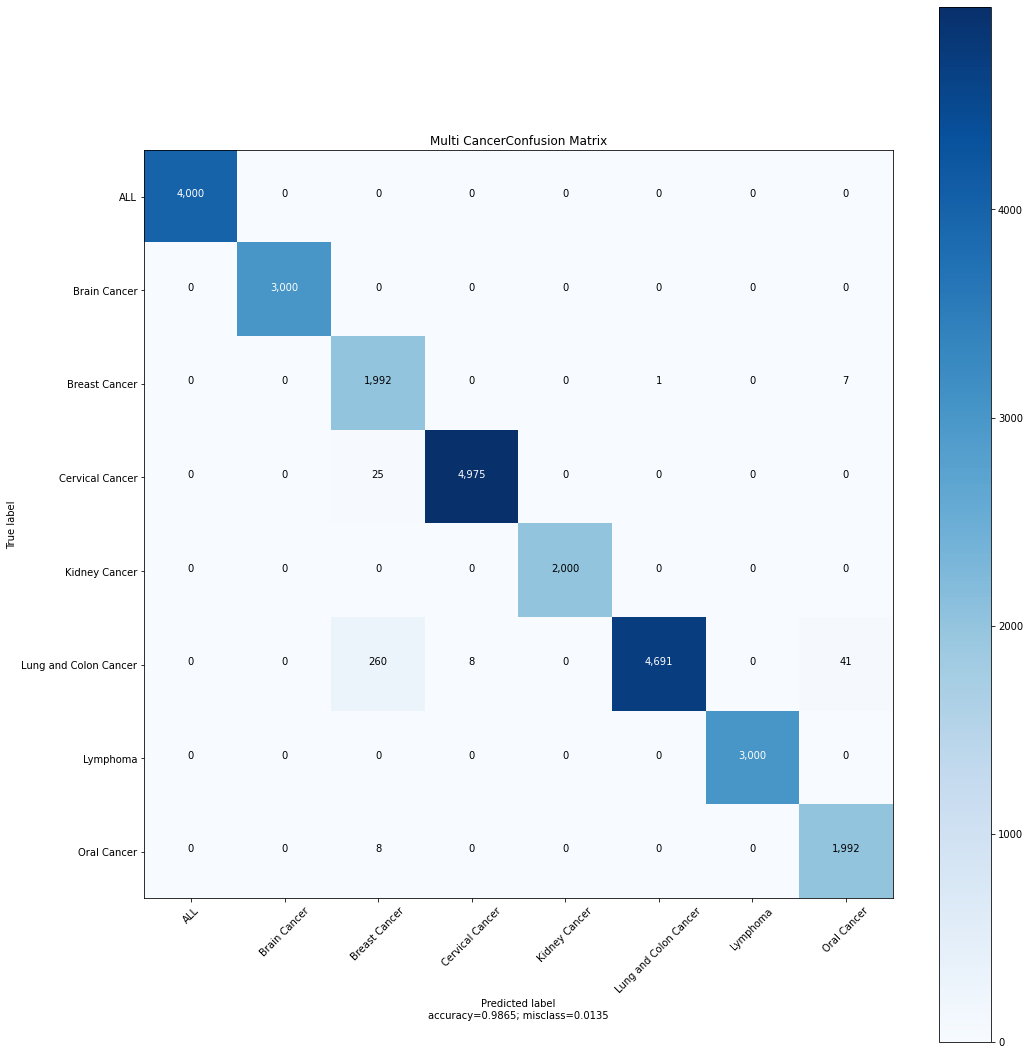

<Figure size 432x288 with 0 Axes>

In [24]:
cpath = os.path.join(mpath, 'Multi Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
# cpath = os.path.join(mpath, 'Lung and Colon Cancer')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# cpath = os.path.join(mpath, 'Oral Cancer')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# cpath = os.path.join(mpath, 'ALL')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# className = 'Kidney Cancer '
# cpath = os.path.join(mpath, 'Kidney Cancer')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# className = 'Breast Cancer '
# cpath = os.path.join(mpath, 'Breast Cancer')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# className = 'Lymphoma '
# cpath = os.path.join(mpath, 'Lymphoma')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)

In [ ]:
# className = 'Brain Cancer '
# cpath = os.path.join(mpath, 'Brain Cancer')
# noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
# curModel = initiateModel(noOfClasses)
# modelSummary(curModel)
# curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
# curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
# plotOutput(curHistory, className, gEpochs)
# evalModel(curModel)
# saveModel(curModel, className)
# callPlot(curModel, className, class_names)